# 나이 모델링

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.models as models
from torchvision import transforms
import time
from tqdm.autonotebook import tqdm
from torch.utils.data import DataLoader
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import inspect
import torch.nn.functional as F
import PIL
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import json
import pandas as pd

<ipython-input-1-3c94b24422a0>:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, files, path, label_list, mode='train', transform=None, target_transform=None):
        self.files = files
        self.transform=transform
        self.target_transform = target_transform
        self.file_path = path
        self.label = label_list


    def __len__(self):
        return len(self.files)

    def __getitem__(self, index):
        image_file_name = self.files['image'][index].split('/')[-1]
        image_path = self.file_path  + image_file_name
        image = Image.open(image_path)

        label_value = self.label.iloc[index].values.astype(np.float32)

        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            image = self.target_transform(image)

        return image, torch.tensor(label_value).float()

In [3]:
train_df = pd.read_json('/content/drive/MyDrive/kiosk/face_crop/label/labels_v1.json',encoding='cp949')
train_age_label_df = pd.get_dummies(train_df['age'])

test_df = pd.read_json('/content/drive/MyDrive/kiosk/face_crop/test_label/test_labels_v1.json',encoding='cp949')
test_age_label_df = pd.get_dummies(test_df['age'])


train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224,224)),
    torchvision.transforms.RandomCrop(224),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
])
test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224,224)),
    torchvision.transforms.ToTensor(),
])

train_datset_path = '/content/drive/MyDrive/kiosk/face_crop/img/'
test_datset_path = '/content/drive/MyDrive/kiosk/face_crop/test_img/'

train_datset = CustomDataset(train_df, train_datset_path, train_age_label_df, transform=train_transform)
test_datset = CustomDataset(test_df, test_datset_path,test_age_label_df, target_transform=test_transform)

In [4]:
train_dataloader = DataLoader(train_datset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_datset, batch_size=64, shuffle=True)

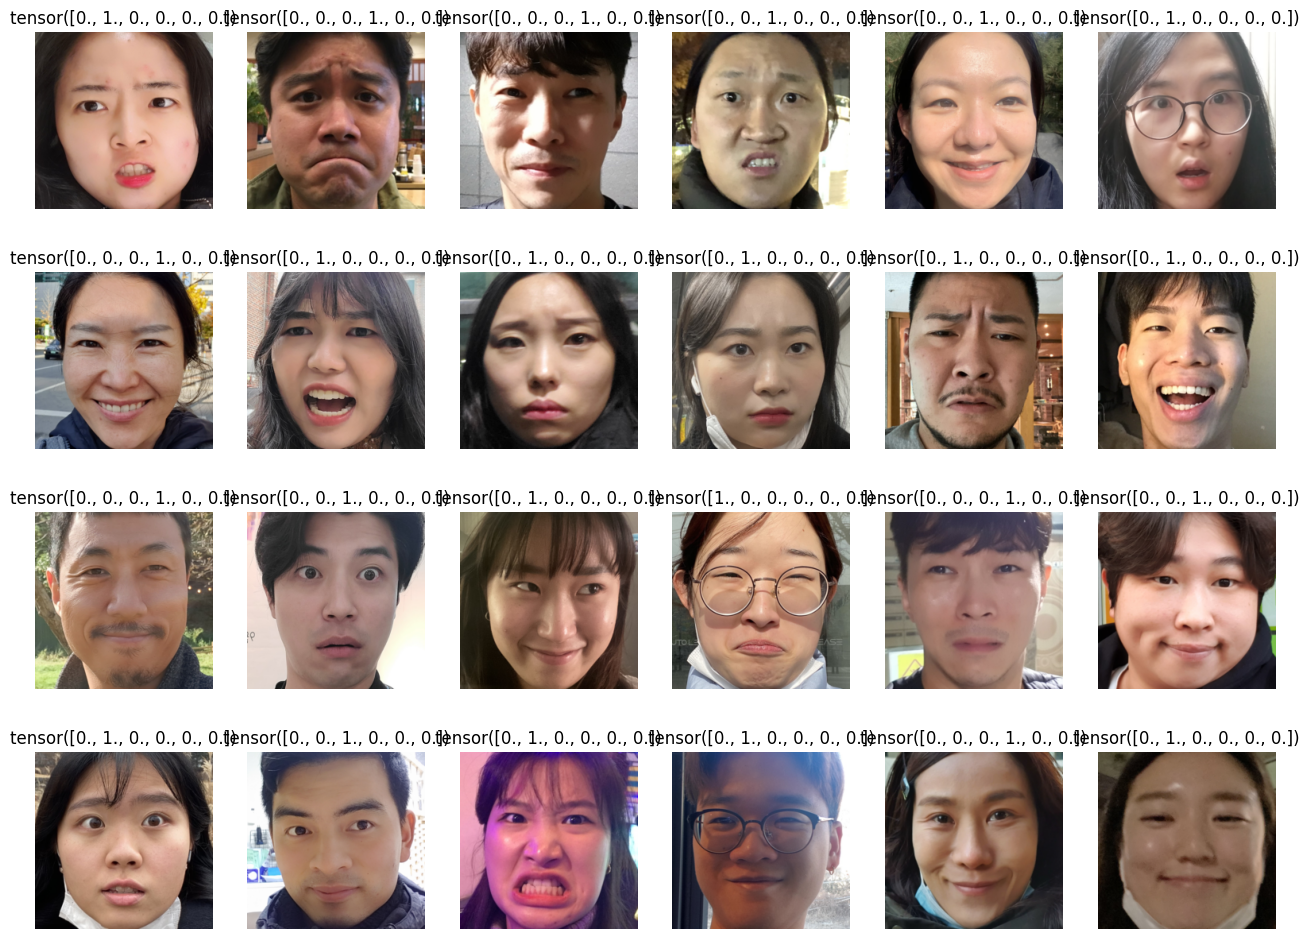

In [5]:
samples, labels = next(iter(train_dataloader))
fig = plt.figure(figsize=(16,24))
for i in range(24):
    a = fig.add_subplot(4,6,i+1)
    a.set_title(labels[i])
    a.axis('off')
    a.imshow(np.transpose(samples[i].numpy(), (1,2,0)))
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)

In [6]:
device='cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [11]:
model = torchvision.models.resnet18(pretrained=True)
model

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [12]:
num_ftrs = model.fc.in_features

model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(num_ftrs, 1024),
    nn.Dropout(0.2),
    nn.Linear(1024, 512),
    nn.Dropout(0.1),
    nn.Linear(512, 6),
    nn.Softmax(dim=0)
)

model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [68]:
def fit(model, criterion, optimizer, epochs, train_loader, valid_loader=None):

    if valid_loader is None:
        valid_loader = train_loader

    model.to(device)
    criterion.to(device)

    model.train()

    train_loss = 0
    train_acc = 0
    train_correct = 0

    train_losses = []
    train_accuracies = []

    valid_losses = []
    valid_accuracies = []

    for epoch in tqdm(range(epochs)):
        start = time.time()
        for train_x, train_y in tqdm(train_loader):
            model.train()
            train_x, train_y = train_x.to(device), train_y.to(device).float()

            optimizer.zero_grad()

            pred = model(train_x)

            loss = criterion(pred, train_y)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            y_pred = torch.argmax(pred, 1)
            y_train = torch.argmax(train_y, 1)
            train_correct += y_pred.eq(y_train).cpu().sum()

        # validation data check
        valid_loss = 0
        valid_acc = 0
        valid_correct = 0

        for valid_x, valid_y in tqdm(valid_loader):
            with torch.no_grad():
                model.eval()
                valid_x, valid_y = valid_x.to(device), valid_y.to(device).float()
                pred = model(valid_x)
                loss = criterion(pred, valid_y)
            valid_loss += loss.item()

            y_pred = torch.argmax(pred, 1)
            y_valid = torch.argmax(valid_y, 1)
            valid_correct += y_pred.eq(y_valid).cpu().sum()

        train_acc = train_correct/len(train_loader.dataset)
        valid_acc = valid_correct/len(valid_loader.dataset)

        print(f'{time.time() - start:.3f}sec : [Epoch {epoch+1}/{epochs}] -> train loss: {train_loss/len(train_loader):.4f}, train acc: {train_acc*100:.3f}% / valid loss: {valid_loss/len(valid_loader):.4f}, valid acc: {valid_acc*100:.3f}%')

        train_losses.append(train_loss/len(train_loader))
        train_accuracies.append(train_acc)
        valid_losses.append(valid_loss/len(valid_loader))
        valid_accuracies.append(valid_acc)

        train_loss = 0
        train_acc = 0
        train_correct = 0

    plt.plot(train_losses, label='loss')
    plt.plot(train_accuracies, label='accuracy')
    plt.legend()
    plt.title('train loss and accuracy')
    plt.show()

    plt.plot(valid_losses, label='loss')
    plt.plot(valid_accuracies, label='accuracy')
    plt.legend()
    plt.title('valid loss and accuracy')
    plt.show()

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

149.624sec : [Epoch 1/20] -> train loss: 1.7528, train acc: 17.301% / valid loss: 1.7661, valid acc: 14.917%


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

149.104sec : [Epoch 2/20] -> train loss: 1.7527, train acc: 18.118% / valid loss: 1.7671, valid acc: 16.500%


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

148.883sec : [Epoch 3/20] -> train loss: 1.7519, train acc: 18.018% / valid loss: 1.7627, valid acc: 17.417%


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

149.006sec : [Epoch 4/20] -> train loss: 1.7525, train acc: 18.836% / valid loss: 1.7648, valid acc: 17.667%


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

149.796sec : [Epoch 5/20] -> train loss: 1.7505, train acc: 19.169% / valid loss: 1.7637, valid acc: 18.750%


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

148.483sec : [Epoch 6/20] -> train loss: 1.7509, train acc: 19.119% / valid loss: 1.7628, valid acc: 15.667%


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

149.858sec : [Epoch 7/20] -> train loss: 1.7507, train acc: 19.353% / valid loss: 1.7644, valid acc: 16.833%


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

149.277sec : [Epoch 8/20] -> train loss: 1.7503, train acc: 20.153% / valid loss: 1.7628, valid acc: 18.000%


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

149.272sec : [Epoch 9/20] -> train loss: 1.7493, train acc: 20.988% / valid loss: 1.7626, valid acc: 20.083%


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

149.382sec : [Epoch 10/20] -> train loss: 1.7477, train acc: 23.207% / valid loss: 1.7640, valid acc: 19.750%


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

151.143sec : [Epoch 11/20] -> train loss: 1.7486, train acc: 23.624% / valid loss: 1.7614, valid acc: 19.667%


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

151.134sec : [Epoch 12/20] -> train loss: 1.7468, train acc: 24.291% / valid loss: 1.7641, valid acc: 20.250%


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

150.620sec : [Epoch 13/20] -> train loss: 1.7459, train acc: 25.125% / valid loss: 1.7619, valid acc: 21.167%


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

150.308sec : [Epoch 14/20] -> train loss: 1.7459, train acc: 25.759% / valid loss: 1.7625, valid acc: 22.000%


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

150.642sec : [Epoch 15/20] -> train loss: 1.7452, train acc: 26.193% / valid loss: 1.7618, valid acc: 21.500%


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

151.027sec : [Epoch 16/20] -> train loss: 1.7454, train acc: 26.276% / valid loss: 1.7608, valid acc: 24.333%


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

150.878sec : [Epoch 17/20] -> train loss: 1.7444, train acc: 27.160% / valid loss: 1.7616, valid acc: 24.167%


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

150.304sec : [Epoch 18/20] -> train loss: 1.7430, train acc: 27.945% / valid loss: 1.7621, valid acc: 24.583%


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

151.427sec : [Epoch 19/20] -> train loss: 1.7436, train acc: 28.712% / valid loss: 1.7600, valid acc: 24.250%


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

150.267sec : [Epoch 20/20] -> train loss: 1.7437, train acc: 28.161% / valid loss: 1.7606, valid acc: 24.083%


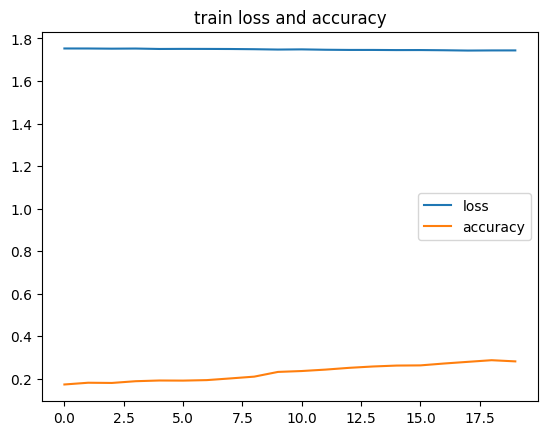

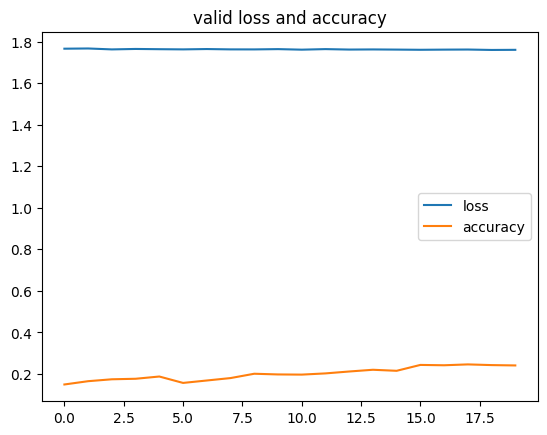

In [70]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

fit(model, criterion, optimizer, 20, train_dataloader, test_dataloader)

In [31]:
pred.shape

NameError: name 'pred' is not defined